In [ ]:
pip install prophet

In [ ]:
pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from prophet import Prophet
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, MultiHeadAttention

In [ ]:
weather_data = pd.read_csv('/content/Larnaca.csv', parse_dates=['DATE'])
weather_data.head()

,STATION,NAME,DATE,PRCP,SNWD,TAVG,TMAX,TMIN
0,CY000176090,"LARNACA, CY",1976-04-04,NaN,NaN,NaN,18.2,NaN
1,CY000176090,"LARNACA, CY",1976-04-05,NaN,NaN,NaN,20.7,8.3
2,CY000176090,"LARNACA, CY",1976-04-06,NaN,NaN,NaN,20.2,8.6
3,CY000176090,"LARNACA, CY",1976-04-07,NaN,NaN,NaN,20.4,9.0
4,CY000176090,"LARNACA, CY",1976-04-08,NaN,NaN,NaN,21.9,8.0


In [ ]:
# Define a function to convert Fahrenheit to Celsius
def fahrenheit_to_celsius(f):
    return (f - 32) * 5.0/9.0

# Convert TMAX, TMIN, and TAVG columns to Celsius (ignoring NaN values)
weather_data['TMAX_C'] = weather_data['TMAX']
weather_data['TMIN_C'] = weather_data['TMIN']
weather_data['TAVG_C'] = weather_data['TAVG']

# Display the first few rows to confirm the conversion
weather_data.head()

,STATION,NAME,DATE,PRCP,SNWD,TAVG,TMAX,TMIN,TMAX_C,TMIN_C,TAVG_C
0,CY000176090,"LARNACA, CY",1976-04-04,NaN,NaN,NaN,18.2,NaN,18.2,NaN,NaN
1,CY000176090,"LARNACA, CY",1976-04-05,NaN,NaN,NaN,20.7,8.3,20.7,8.3,NaN
2,CY000176090,"LARNACA, CY",1976-04-06,NaN,NaN,NaN,20.2,8.6,20.2,8.6,NaN
3,CY000176090,"LARNACA, CY",1976-04-07,NaN,NaN,NaN,20.4,9.0,20.4,9.0,NaN
4,CY000176090,"LARNACA, CY",1976-04-08,NaN,NaN,NaN,21.9,8.0,21.9,8.0,NaN


In [ ]:
weather_data['TMAX_C'].fillna(method='ffill', inplace=True)  # Forward fill
weather_data['TMAX_C'].fillna(method='bfill', inplace=True)  # Backward fill (if forward fill is incomplete)

weather_data['TMIN_C'].fillna(method='ffill', inplace=True)  # Forward fill
weather_data['TMIN_C'].fillna(method='bfill', inplace=True)  # Backward fill (if forward fill is incomplete)

weather_data['TAVG_C'].fillna(method='ffill', inplace=True)  # Forward fill
weather_data['TAVG_C'].fillna(method='bfill', inplace=True)  # Backward fill (if forward fill is incomplete)

<ipython-input-6-2643140564>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  weather_data['TMAX_C'].fillna(method='ffill', inplace=True)  # Forward fill
<ipython-input-6-2643140564>:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['TMAX_C'].fillna(method='ffill', inplace=True)  # Forward fill
<ipython-input-6-2643140564>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignmen

In [ ]:
#12°C is tbase, as olives generally begin to grow and develop at temperatures above this threshold.
# Function to calculate GDD
def calculate_gdd(Tmax, Tmin, Tbase=12):
    return np.maximum(0, (Tmax + Tmin) / 2 - Tbase)

weather_data['GDD'] = calculate_gdd(weather_data['TMAX_C'], weather_data['TMIN_C'])

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Standardize and scale the data
scaler_residuals = StandardScaler()
scaler_TMAX_C = MinMaxScaler(feature_range=(0, 1))
scaler_GDD = StandardScaler()

# Fit and transform historical data
weather_data['TMAX_C_scaled'] = scaler_TMAX_C.fit_transform(
    weather_data['TMAX_C'].values.reshape(-1, 1))
weather_data['GDD_scaled'] = scaler_GDD.fit_transform(
    weather_data['GDD'].values.reshape(-1, 1))

In [ ]:
# Step 1: Decompose with Prophet
from prophet import Prophet
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout

# Prepare the data for Prophet
prophet_data = weather_data[['DATE', 'TMAX_C']]
prophet_data.columns = ['ds', 'y']  # Prophet requires these column names

# Fit Prophet model
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(prophet_data)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpayb4zy9m/05x9ekj8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpayb4zy9m/88j4j3f2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37153', 'data', 'file=/tmp/tmpayb4zy9m/05x9ekj8.json', 'init=/tmp/tmpayb4zy9m/88j4j3f2.json', 'output', 'file=/tmp/tmpayb4zy9m/prophet_model26kqvbc7/prophet_model-20250615070657.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:06:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:06:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

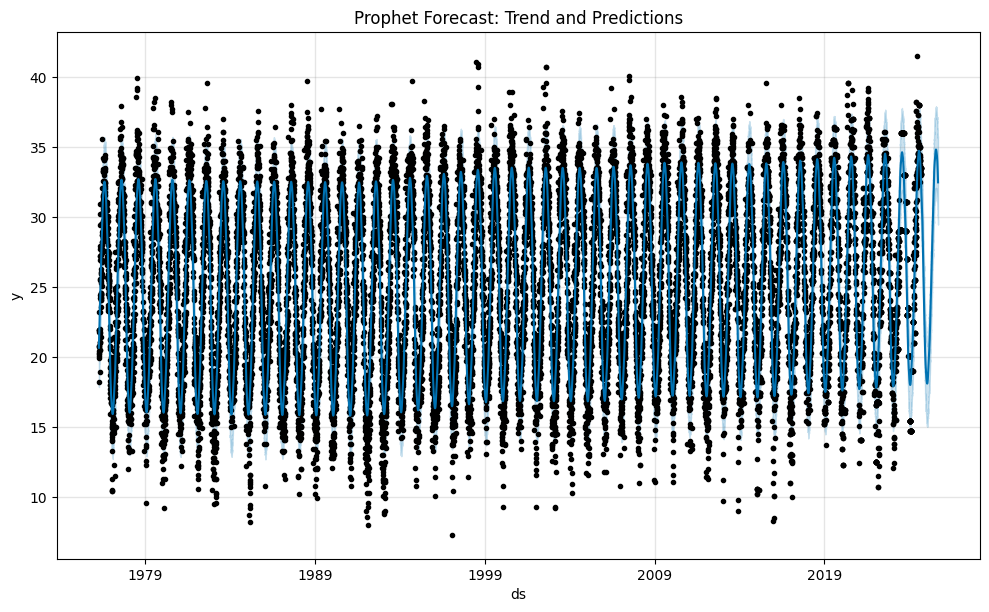

<Figure size 1000x800 with 0 Axes>

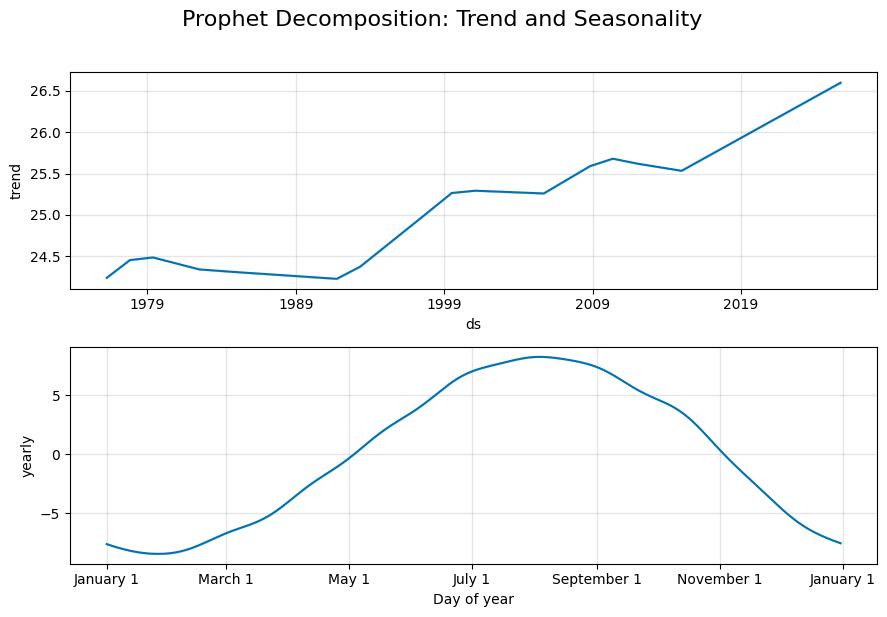

In [ ]:
import matplotlib.pyplot as plt

# Predict future values to visualize trends and seasonality
future = model.make_future_dataframe(periods=365)  # Extend the dataframe for one year
forecast = model.predict(future)

# Plot the forecast
plt.figure(figsize=(10, 6))
model.plot(forecast)
plt.title("Prophet Forecast: Trend and Predictions")
plt.show()

# Plot the components (Trend and Seasonality)
plt.figure(figsize=(10, 8))
model.plot_components(forecast)
plt.suptitle("Prophet Decomposition: Trend and Seasonality", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# Generate future dataframe
future = model.make_future_dataframe(periods=0)  # Only use the existing data
forecast = model.predict(future)

In [ ]:
print(forecast.columns)

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')


In [ ]:
# Add trend and seasonality components to the original data
weather_data['trend'] = forecast['trend']
weather_data['seasonality'] = forecast['yearly']

In [ ]:
weather_data.head()

,STATION,NAME,DATE,PRCP,SNWD,TAVG,TMAX,TMIN,TMAX_C,TMIN_C,TAVG_C,GDD,TMAX_C_scaled,GDD_scaled,trend,seasonality
0,CY000176090,"LARNACA, CY",1976-04-04,NaN,NaN,NaN,18.2,NaN,18.2,8.3,9.3,1.25,0.318713,-1.182328,24.241395,-3.584679
1,CY000176090,"LARNACA, CY",1976-04-05,NaN,NaN,NaN,20.7,8.3,20.7,8.3,9.3,2.50,0.391813,-0.966250,24.241774,-3.447237
2,CY000176090,"LARNACA, CY",1976-04-06,NaN,NaN,NaN,20.2,8.6,20.2,8.6,9.3,2.40,0.377193,-0.983536,24.242152,-3.310927
3,CY000176090,"LARNACA, CY",1976-04-07,NaN,NaN,NaN,20.4,9.0,20.4,9.0,9.3,2.70,0.383041,-0.931678,24.242531,-3.176194
4,CY000176090,"LARNACA, CY",1976-04-08,NaN,NaN,NaN,21.9,8.0,21.9,8.0,9.3,2.95,0.426901,-0.888462,24.242909,-3.043418


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Standardize and scale the data
scaler_trend = StandardScaler()
scaler_seasonality = StandardScaler()
scaler_TMAX_C = MinMaxScaler(feature_range=(0, 1))
scaler_GDD = StandardScaler()

# Fit and transform historical data
weather_data['trend_scaled'] = scaler_trend.fit_transform(
    weather_data['trend'].values.reshape(-1, 1))
weather_data['seasonality_scaled'] = scaler_seasonality.fit_transform(
    weather_data['seasonality'].values.reshape(-1, 1))  # Scaling the added seasonality column
weather_data['TMAX_C_scaled'] = scaler_TMAX_C.fit_transform(
    weather_data['TMAX_C'].values.reshape(-1, 1))
weather_data['GDD_scaled'] = scaler_GDD.fit_transform(
    weather_data['GDD'].values.reshape(-1, 1))

# Verify the scaled data
print(weather_data[['trend_scaled', 'seasonality_scaled', 'TMAX_C_scaled', 'GDD_scaled']].head())


   trend_scaled  seasonality_scaled  TMAX_C_scaled  GDD_scaled
0     -1.251302           -0.617552       0.318713   -1.182328
1     -1.250741           -0.594161       0.391813   -0.966250
2     -1.250180           -0.570963       0.377193   -0.983536
3     -1.249619           -0.548033       0.383041   -0.931678
4     -1.249058           -0.525436       0.426901   -0.888462


In [ ]:
import numpy as np
import tensorflow as tf

# Step 2: Train-Test Split
features = ['trend_scaled', 'seasonality_scaled', 'GDD_scaled', 'TMAX_C_scaled']  # Use trend, seasonality, and GDD
target = 'TMAX_C_scaled'  # Scaled target variable

# Extract features and target as numpy arrays
X = weather_data[features].values
y = weather_data[target].values

# Number of samples in the dataset
num_samples = X.shape[0]

# Define sequence length
sequence_length = 30  # Adjust based on your model's requirement

# Define a function to create sequences for X (features) and y (target)
def create_sequences(features, target, seq_length):
    X_seq = []
    y_seq = []
    for i in range(len(features) - seq_length):
        X_seq.append(features[i:i + seq_length])
        y_seq.append(target[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

# Create sequences for the entire dataset
X_seq, y_seq = create_sequences(X, y, sequence_length)

# Verify the shapes of sequences
print(f"X_seq shape: {X_seq.shape}")
print(f"y_seq shape: {y_seq.shape}")

# Train-Test Split
train_val_size = int(0.8 * len(X_seq))  # 80% for training and validation
val_size = int(0.25 * train_val_size)  # 25% of train_val is used for validation

# Split the data into training + validation and test sets
X_train_val, X_test = X_seq[:train_val_size], X_seq[train_val_size:]
y_train_val, y_test = y_seq[:train_val_size], y_seq[train_val_size:]

# Split training + validation into training and validation sets
X_train, X_val = X_train_val[:-val_size], X_train_val[-val_size:]
y_train, y_val = y_train_val[:-val_size], y_train_val[-val_size:]

# Verify the shapes of training, validation, and


X_seq shape: (17658, 30, 4)
y_seq shape: (17658,)


In [ ]:
# Verify the shapes of sequences
print(f"X_seq shape: {X_seq.shape}")
print(f"y_seq shape: {y_seq.shape}")

X_seq shape: (17658, 30, 4)
y_seq shape: (17658,)


In [ ]:
# Print mean and standard deviation for each feature across the training set
for feature_idx in range(X_train.shape[2]):
    feature_values = X_train[:, :, feature_idx].flatten()  # Flatten to get all values of a feature
    print(f"Feature {feature_idx + 1} - Mean: {np.mean(feature_values):.4f}, Std: {np.std(feature_values):.4f}")


Feature 1 - Mean: -0.6814, Std: 0.5943
Feature 2 - Mean: -0.0076, Std: 1.0000
Feature 3 - Mean: -0.0849, Std: 0.9817
Feature 4 - Mean: 0.5068, Std: 0.1847


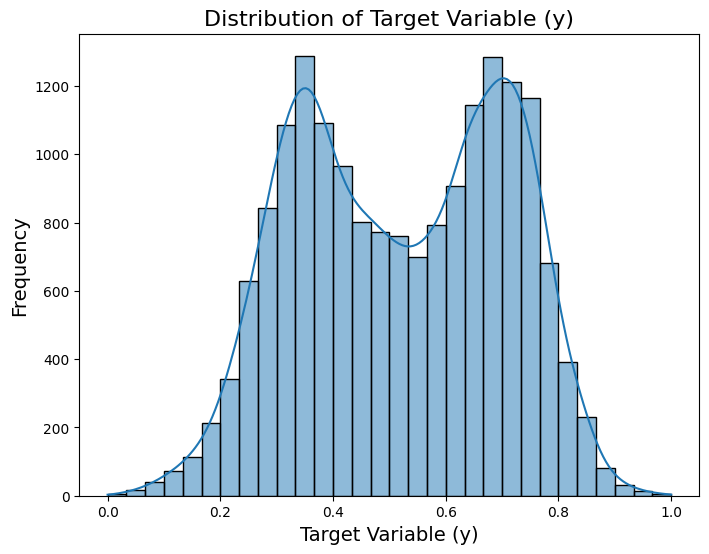

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of the target variable y
plt.figure(figsize=(8, 6))

# Plot the distribution of the target variable with Kernel Density Estimate (KDE)
sns.histplot(y, kde=True, bins=30)

# Add labels and title
plt.title("Distribution of Target Variable (y)", fontsize=16)
plt.xlabel("Target Variable (y)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Show the plot
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
import random
import os

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seed(42)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

# Define the GRU model
gru_model = Sequential([
    GRU(units=98, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),  # Dropout for regularization
    GRU(units=32, return_sequences=False),  # Return a single vector
    Dropout(0.3),  # Dropout for regularization
    Dense(units=1)  # Single output neuron for regression
])

# Compile the model
gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0424 - mae: 0.1339 - val_loss: 0.0035 - val_mae: 0.0450 - learning_rate: 0.0010
Epoch 2/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0086 - mae: 0.0725 - val_loss: 0.0030 - val_mae: 0.0402 - learning_rate: 0.0010
Epoch 3/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0068 - mae: 0.0638 - val_loss: 0.0031 - val_mae: 0.0420 - learning_rate: 0.0010
Epoch 4/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0058 - mae: 0.0595 - val_loss: 0.0031 - val_mae: 0.0420 - learning_rate: 0.0010
Epoch 5/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0049 - mae: 0.0543 - val_loss: 0.0027 - val_mae: 0.0387 - learning_rate: 0.0010
Epoch 6/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0045 - mae: 0.0513 - val_loss: 0.0025 - val_mae: 0.0377 - learning_rate: 0.0010
Epoch 7/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0041 - mae: 0.0493 - val_loss: 0.0025 - val_mae: 0.0369 - learning_rate: 0.0010
Epoch 

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test Loss (MSE): 0.00225
Test MAE: 0.03411
Test MAPE: 8.02
Test R²: 0.937


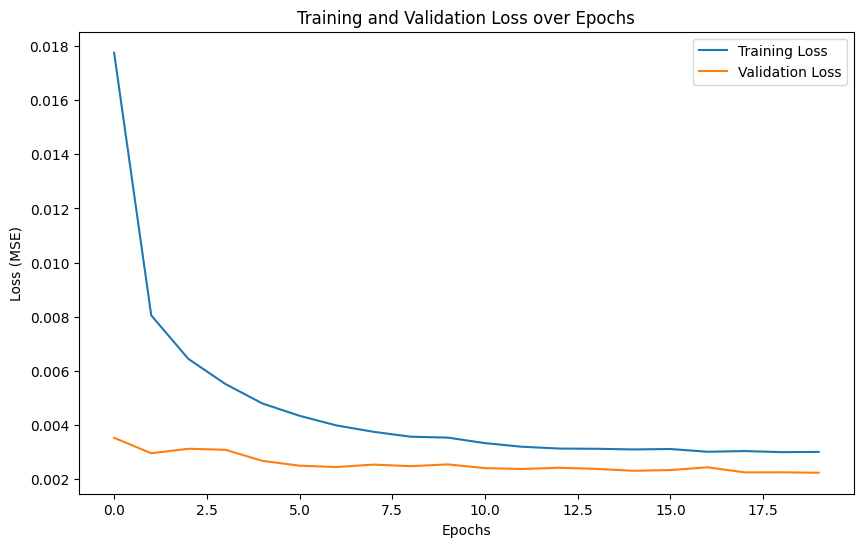

In [ ]:
# Evaluate the hybrid GRU + Attention model on the test set
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
# Evaluate the hybrid GRU + Attention model on the test set
y_pred = gru_model.predict(X_test)
test_loss = mean_squared_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)
test_mape = mean_absolute_percentage_error(y_test, y_pred)*100
test_r2 = r2_score(y_test, y_pred)

print(f"Test Loss (MSE): {test_loss:.5f}")
print(f"Test MAE: {test_mae:.5f}")
print(f"Test MAPE: {test_mape:.2f}")
print(f"Test R²: {test_r2:.3f}")

results = []
results.append(['Hybrid GRU + Attention', test_loss, test_mae, test_mape, test_r2])

# Plot training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

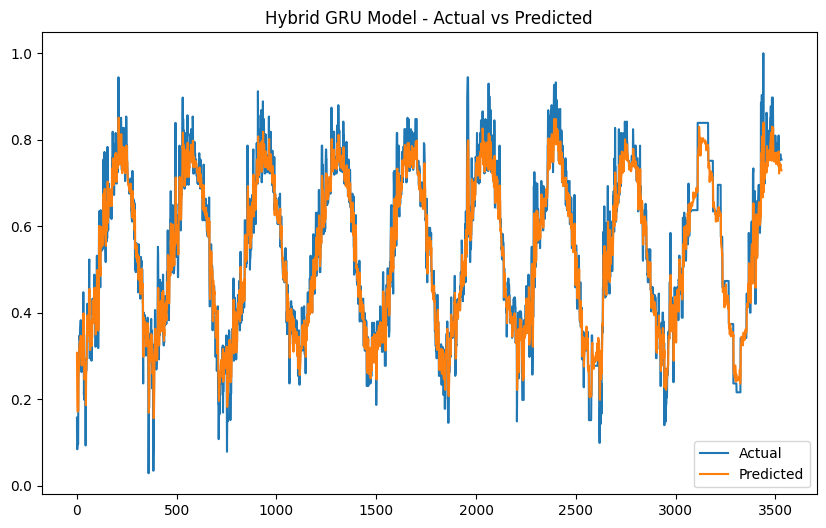

In [ ]:
y_pred_gru = y_pred

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred_gru, label='Predicted')
plt.title('Hybrid GRU Model - Actual vs Predicted')
plt.legend()
plt.show()

In [ ]:
pip install statsmodels

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import LinearRegression
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

# Define features and target for LSTM/GRU baselines
baseline_features = ['TMAX_C_scaled', 'GDD_scaled']
baseline_target = 'TMAX_C_scaled'

# Extract baseline features and target
X_baseline = weather_data[baseline_features].values
y_baseline = weather_data[baseline_target].values

# Split data into train/test for baselines
train_size = int(0.8 * len(X_baseline))
X_train_base, X_test_base = X_baseline[:train_size], X_baseline[train_size:]
y_train_base, y_test_base = y_baseline[:train_size], y_baseline[train_size:]

# Reshape X_train/X_test for LSTM and GRU
sequence_length = 30  # Sequence length for time series
X_train_seq = []
y_train_seq = []
for i in range(len(X_train_base) - sequence_length):
    X_train_seq.append(X_train_base[i:i+sequence_length])
    y_train_seq.append(y_train_base[i+sequence_length])
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)

X_test_seq = []
y_test_seq = []
for i in range(len(X_test_base) - sequence_length):
    X_test_seq.append(X_test_base[i:i+sequence_length])
    y_test_seq.append(y_test_base[i+sequence_length])
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def calculate_mape(y_true, y_pred):
   return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Model 1: Simple Moving Average (SMA)
sma_window = 7  # Define SMA window
y_pred_sma = np.convolve(y_train_base, np.ones(sma_window)/sma_window, mode='valid')
y_pred_sma = y_pred_sma[-len(y_test_base):]  # Align with test set
mse_sma = mean_squared_error(y_test_base, y_pred_sma)
mae_sma = mean_absolute_error(y_test_base, y_pred_sma)
mape_sma = calculate_mape(y_test_base, y_pred_sma)
r2_sma = r2_score(y_test_base, y_pred_sma)

# Model 2: SARIMA
sarima_order = (1, 1, 1)
sarima_model = SARIMAX(y_train_base, order=sarima_order, seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit(disp=False)
y_pred_sarima = sarima_fit.forecast(steps=len(y_test_base))
mse_sarima = mean_squared_error(y_test_base, y_pred_sarima)
mae_sarima = mean_absolute_error(y_test_base, y_pred_sarima)
mape_sarima = calculate_mape(y_test_base, y_pred_sarima)
r2_sarima = r2_score(y_test_base, y_pred_sarima)

# Model 3: LSTM
lstm_model = Sequential([
   LSTM(64, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
   Dropout(0.3),
   LSTM(32, return_sequences=False),
   Dense(1)
])
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
lstm_model.fit(X_train_seq, y_train_seq, validation_split=0.2, epochs=10, batch_size=32, verbose=1)
y_pred_lstm = lstm_model.predict(X_test_seq).flatten()
mse_lstm = mean_squared_error(y_test_seq, y_pred_lstm)
mae_lstm = mean_absolute_error(y_test_seq, y_pred_lstm)
mape_lstm = calculate_mape(y_test_seq, y_pred_lstm)
r2_lstm = r2_score(y_test_seq, y_pred_lstm)

#  Model 4: GRU
gru_model = Sequential([
   GRU(64, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
   Dropout(0.3),
   GRU(32, return_sequences=False),
   Dense(1)
])
gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
gru_model.fit(X_train_seq, y_train_seq, validation_split=0.2, epochs=10, batch_size=32, verbose=1)
y_pred_gru = gru_model.predict(X_test_seq).flatten()
mse_gru = mean_squared_error(y_test_seq, y_pred_gru)
mae_gru = mean_absolute_error(y_test_seq, y_pred_gru)
mape_gru = calculate_mape(y_test_seq, y_pred_gru)
r2_gru = r2_score(y_test_seq, y_pred_gru)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


353/353 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0216 - val_loss: 0.0035
Epoch 2/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0042 - val_loss: 0.0032
Epoch 3/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 4/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0034 - val_loss: 0.0028
Epoch 5/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 6/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 7/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 8/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 9/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 10/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0029 - val_loss: 0.0026
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


353/353 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0300 - val_loss: 0.0028
Epoch 2/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 3/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 4/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 5/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 6/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 7/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 8/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 9/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 10/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0027 - val_loss: 0.0025
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
results.append(['GRU', mse_gru, mae_gru, mape_gru, r2_gru])
results.append(['LSTM', mse_lstm, mae_lstm, mape_lstm, r2_lstm])
results.append(['SARIMA', mse_sarima, mae_sarima, mape_sarima, r2_sarima])
results.append(['SMA', mse_sma, mae_sma, mape_sma, r2_sma])

In [ ]:

# Print results
for model_name, mse, mae, mape, r2 in results:
   print(f"Model: {model_name}, MSE: {mse:.5f}, MAE: {mae:.5f}, R²: {r2:.3f}, MAPE: {mape:.2f}%")


Model: Hybrid GRU + Attention, MSE: 0.00225, MAE: 0.03411, R²: 0.937, MAPE: 8.02%
Model: GRU, MSE: 0.00225, MAE: 0.03273, R²: 0.937, MAPE: 7.33%
Model: LSTM, MSE: 0.00235, MAE: 0.03515, R²: 0.934, MAPE: 8.09%
Model: SARIMA, MSE: 0.06318, MAE: 0.20526, R²: -0.760, MAPE: 36.57%
Model: SMA, MSE: 0.08641, MAE: 0.25884, R²: -1.407, MAPE: 58.29%


In [ ]:
# Convert results to DataFrame for comparison
results_df= pd.DataFrame(results, columns=['Model', 'MSE', 'MAE', 'R²', 'MAPE'])

# Display the results
print(results_df)

                    Model       MSE       MAE         R²      MAPE
0  Hybrid GRU + Attention  0.002247  0.034115   8.019850  0.937356
1                     GRU  0.002247  0.032729   7.326239  0.936621
2                    LSTM  0.002346  0.035148   8.089868  0.933820
3                  SARIMA  0.063184  0.205265  36.570927 -0.760416
4                     SMA  0.086408  0.258841  58.290904 -1.407479


Best Model: GRU


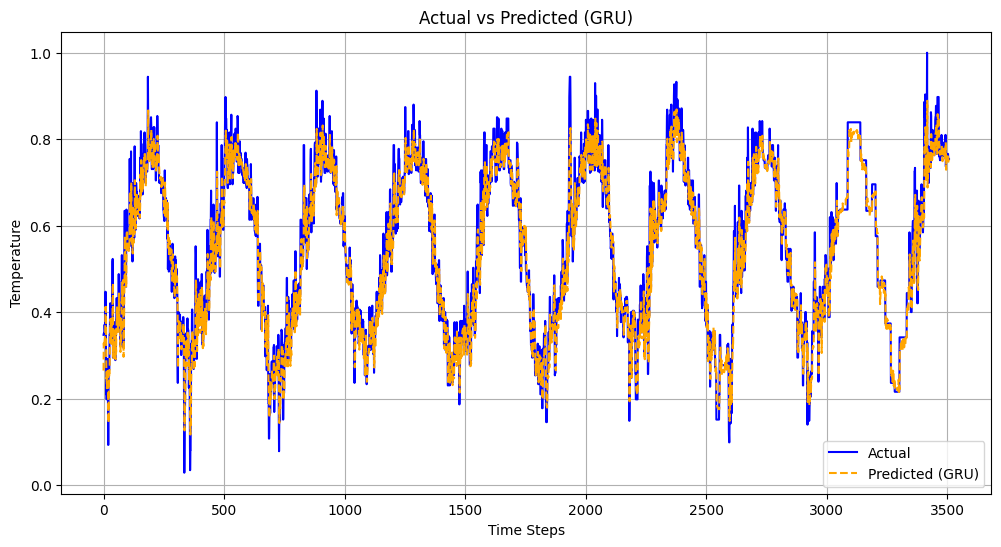

In [ ]:
import matplotlib.pyplot as plt

# Create results DataFrame
import pandas as pd

# Find the best model based on MAE
best_model_index = results_df['MAE'].idxmin()  # Get index of the lowest MAE
best_model_name = results_df.loc[best_model_index]['Model']
print(f"Best Model: {best_model_name}")

# Predict based on the best model
if best_model_name == 'SMA':
    y_pred_best = y_pred_sma
elif best_model_name == 'SARIMA':
    y_pred_best = y_pred_sarima
elif best_model_name == 'LSTM':
    y_pred_best = y_pred_lstm
elif best_model_name == 'GRU':
    y_pred_best = y_pred_gru
elif best_model_name == 'Hybrid GRU + Attention':
    y_pred_best = gru_model.predict(X_test_seq).flatten()  # Predict with Hybrid GRU + Attention
else:
    raise ValueError(f"Model '{best_model_name}' not recognized.")

# Plot Actual vs Predicted for the best model
plt.figure(figsize=(12, 6))
plt.plot(y_test_seq, label='Actual', color='blue')  # Actual values
plt.plot(y_pred_best, label=f'Predicted ({best_model_name})', linestyle='--', color='orange')  # Predicted values
plt.title(f'Actual vs Predicted ({best_model_name})')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()


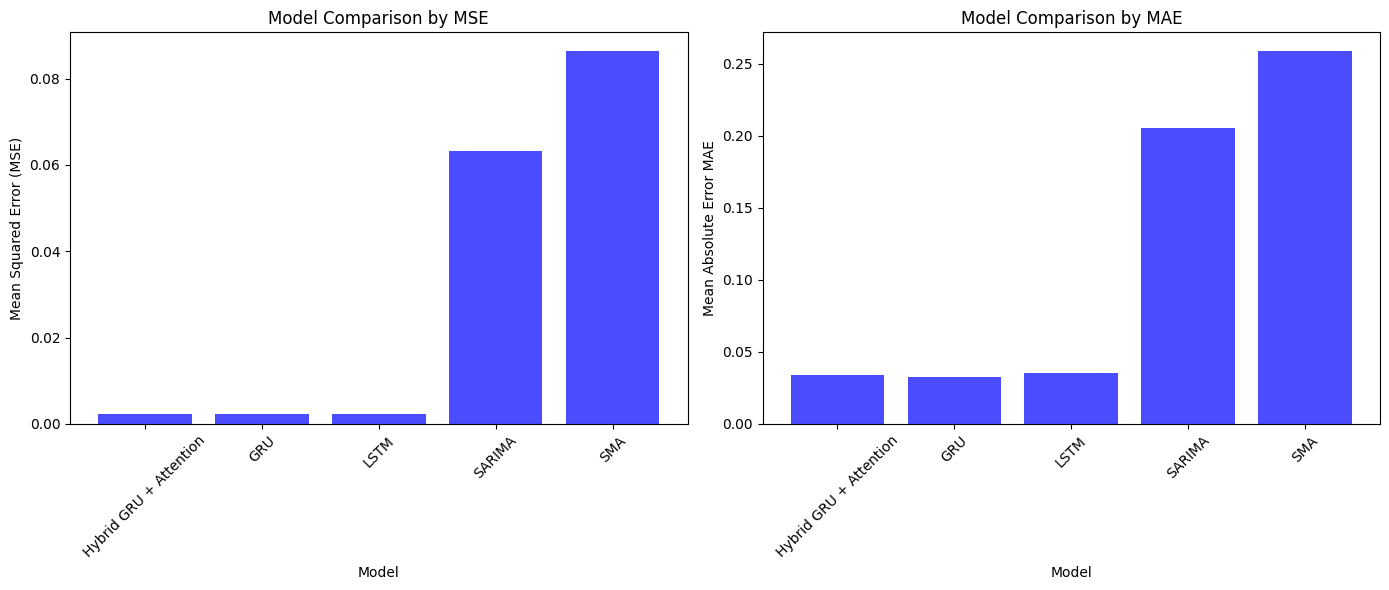

In [ ]:
import matplotlib.pyplot as plt

# Plotting comparison of models based on MSE and MAE
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# MSE Plot
ax[0].bar(results_df["Model"], results_df["MSE"], color='blue', alpha=0.7)
ax[0].set_title("Model Comparison by MSE")
ax[0].set_ylabel("Mean Squared Error (MSE)")
ax[0].set_xlabel("Model")
ax[0].tick_params(axis='x', rotation=45)

# R² Plot
ax[1].bar(results_df["Model"], results_df["MAE"], color='blue', alpha=0.7)
ax[1].set_title("Model Comparison by MAE")
ax[1].set_ylabel("Mean Absolute Error MAE")
ax[1].set_xlabel("Model")
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error: {mape * 100}%")

Mean Absolute Percentage Error: 8.019850329140814%


In [ ]:
weather_data.tail()

,STATION,NAME,DATE,PRCP,SNWD,TAVG,TMAX,TMIN,TMAX_C,TMIN_C,TAVG_C,GDD,TMAX_C_scaled,GDD_scaled,trend,seasonality,trend_scaled,seasonality_scaled
17683,CY000176090,"LARNACA, CY",2024-09-11,0.0,NaN,27.9,NaN,22.9,33.5,22.9,27.9,16.2,0.766082,1.401966,26.495113,6.484616,2.090185,1.096115
17684,CY000176090,"LARNACA, CY",2024-09-12,0.0,NaN,28.5,33.1,22.5,33.1,22.5,28.5,15.8,0.754386,1.332821,26.495385,6.379811,2.090588,1.078278
17685,CY000176090,"LARNACA, CY",2024-09-13,0.0,NaN,27.8,NaN,NaN,33.1,22.5,27.8,15.8,0.754386,1.332821,26.495657,6.273793,2.090990,1.060235
17686,CY000176090,"LARNACA, CY",2024-09-14,0.0,NaN,28.1,33.1,NaN,33.1,22.5,28.1,15.8,0.754386,1.332821,26.495928,6.167145,2.091393,1.042085
17687,CY000176090,"LARNACA, CY",2024-09-17,NaN,NaN,29.0,NaN,NaN,33.1,22.5,29.0,15.8,0.754386,1.332821,26.496743,5.849208,2.092601,0.987976


In [ ]:
#weather_df = pd.read_csv('/content/3897969.csv', parse_dates=['DATE'])

In [ ]:
 # weather_df['TMAX'].fillna(method='ffill', inplace=True)  # Forward fill
  #weather_df['TMAX'].fillna(method='bfill', inplace=True)  # Backward fill (if forward fill is incomplete)

 # weather_df['TMIN'].fillna(method='ffill', inplace=True)  # Forward fill
 # weather_df['TMIN'].fillna(method='bfill', inplace=True)  # Backward fill (if forward fill is incomplete)

 # weather_df['TAVG'].fillna(method='ffill', inplace=True)  # Forward fill
 # weather_df['TAVG'].fillna(method='bfill', inplace=True)  # Backward fill (if forward fill is incomplete)#

my model demonstrates better accuracy (lower MSE and MAE) compared to traditional (SARIMA, SMA) and advanced models (LSTM). This positions it as a high-performing alternative in time-series weather prediction.

In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta

API_KEY = '...'
BASE_URL = 'https://api.openweathermap.org/data/2.5/forecast'


def fetch_weather_data(lat, lon, start_date, end_date):
    """
    Fetch weather forecast data from OpenWeatherMap API.
    """
    # Get 5-day forecast with 3-hour steps
    url = f"{BASE_URL}?lat={lat}&lon={lon}&appid={API_KEY}&units=metric"

    try:
        response = requests.get(url)
        response.raise_for_status()
        weather_json = response.json()

        data = []
        if 'list' in weather_json:
            # Group by date and get daily min/max
            daily_temps = {}

            for item in weather_json['list']:
                date = datetime.utcfromtimestamp(item['dt']).strftime('%Y-%m-%d')
                temp = item['main']['temp']

                if date not in daily_temps:
                    daily_temps[date] = {'min': temp, 'max': temp}
                else:
                    daily_temps[date]['min'] = min(daily_temps[date]['min'], temp)
                    daily_temps[date]['max'] = max(daily_temps[date]['max'], temp)

            # Convert to list for DataFrame
            for date, temps in daily_temps.items():
                data.append([date, temps['max'], temps['min']])

            weather_df = pd.DataFrame(data, columns=["Date", "TMAX", "TMIN"])
            return weather_df.sort_values('Date').reset_index(drop=True)

    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {str(e)}")
        return pd.DataFrame()

# Example usage
lat, lon = 34.9177, 33.6250  # Coordinates for Larnaca, Cyprus
start_date = "2025-01-01"
end_date = "2025-01-05"

forecast_df = fetch_weather_data(lat, lon, start_date, end_date)

if not forecast_df.empty:
    print("Weather Forecast Data:")
    print(forecast_df)
else:
    print("No data available.")


forecast_df.to_csv("realtime_weather_data.csv", index=False)

Weather Forecast Data:
         Date   TMAX   TMIN
0  2025-06-15  28.84  24.81
1  2025-06-16  28.68  22.41
2  2025-06-17  29.88  24.76
3  2025-06-18  31.10  24.41
4  2025-06-19  29.75  25.30
5  2025-06-20  28.15  24.87


In [ ]:
# Calculate GDD (Growing Degree Days)
def calculate_gdd(tmax, tmin, base_temp=10):
    return np.maximum(0, (tmax + tmin) / 2 - base_temp)

# Add GDD to the forecast data
forecast_df['GDD'] = calculate_gdd(forecast_df['TMAX'], forecast_df['TMIN'])

# Create new scalers and fit them on forecast data
scaler_TMAX_C = MinMaxScaler(feature_range=(0, 1))
scaler_GDD = StandardScaler()

# Fit and transform the data
forecast_df['TMAX_scaled'] = scaler_TMAX_C.fit_transform(forecast_df['TMAX'].values.reshape(-1, 1))
forecast_df['GDD_scaled'] = scaler_GDD.fit_transform(forecast_df['GDD'].values.reshape(-1, 1))

# Prepare features for prediction
forecast_features = ['TMAX_scaled', 'GDD_scaled']
X_forecast = forecast_df[forecast_features].values

# Create sequences for prediction
sequence_length = 30

def create_sequences(data, seq_length):
    sequences = []
    # Since we have only 6 days of data, replicate it to create full sequences
    num_replications = (seq_length // len(data)) + 1
    replicated_data = np.tile(data, (num_replications, 1))[:seq_length]

    # Create a sequence for each day we want to predict
    for i in range(len(data)):
        if i == 0:
            seq = replicated_data
        else:
            seq = np.vstack((replicated_data[i:], data[:i]))
        sequences.append(seq)
    return np.array(sequences)

X_forecast_seq = create_sequences(X_forecast, sequence_length)

# Make predictions using the trained model
predictions = gru_model.predict(X_forecast_seq)

# Inverse transform the predictions to get actual temperatures
predictions_original_scale = scaler_TMAX_C.inverse_transform(predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


In [ ]:

# Add predictions to the forecast dataframe
forecast_df['Predicted_TMAX'] = predictions_original_scale

# Display results
print("\nFinal Forecast Results:")
print(forecast_df[['Date', 'TMAX', 'Predicted_TMAX']].to_string())




Final Forecast Results:
         Date   TMAX  Predicted_TMAX
0  2025-06-15  28.84       28.588573
1  2025-06-16  28.68       29.002644
2  2025-06-17  29.88       28.588026
3  2025-06-18  31.10       29.558439
4  2025-06-19  29.75       30.220606
5  2025-06-20  28.15       29.687132


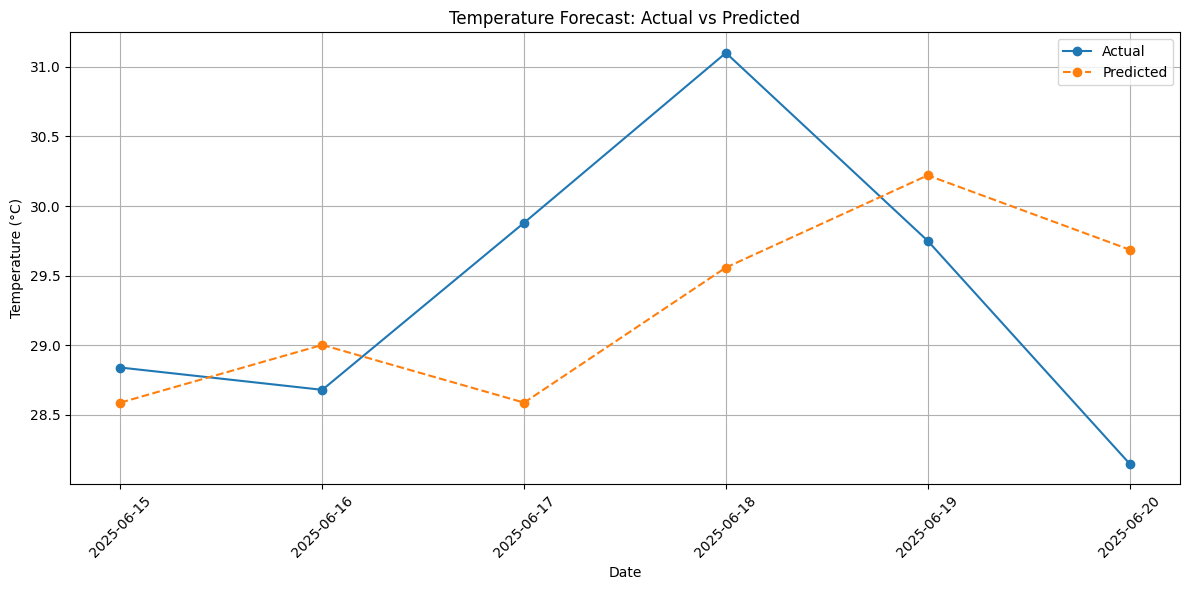

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(forecast_df['Date'], forecast_df['TMAX'], label='Actual', marker='o')
plt.plot(forecast_df['Date'], forecast_df['Predicted_TMAX'], label='Predicted', marker='o', linestyle='--')
plt.title('Temperature Forecast: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate and display error metrics
mse = mean_squared_error(forecast_df['TMAX'], forecast_df['Predicted_TMAX'])
mae = mean_absolute_error(forecast_df['TMAX'], forecast_df['Predicted_TMAX'])
r2 = r2_score(forecast_df['TMAX'], forecast_df['Predicted_TMAX'])


In [ ]:

print("\nForecast Performance Metrics:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")


Forecast Performance Metrics:
Mean Squared Error: 1.1329
Mean Absolute Error: 0.9026
R² Score: -0.2057


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Calculate GDD (Growing Degree Days)
def calculate_gdd(tmax, tmin, base_temp=10):
    return np.maximum(0, (tmax + tmin) / 2 - base_temp)

# Add GDD to the historical data
forecast_df['GDD'] = calculate_gdd(forecast_df['TMAX'], forecast_df['TMIN'])

# Create new scalers and fit them on historical data
scaler_TMAX_C = MinMaxScaler(feature_range=(0, 1))
scaler_GDD = StandardScaler()

# Fit and transform the data
forecast_df['TMAX_scaled'] = scaler_TMAX_C.fit_transform(forecast_df['TMAX'].values.reshape(-1, 1))
forecast_df['GDD_scaled'] = scaler_GDD.fit_transform(forecast_df['GDD'].values.reshape(-1, 1))

# Prepare features for prediction
forecast_features = ['TMAX_scaled', 'GDD_scaled']
X_forecast = forecast_df[forecast_features].values

# Create sequences for prediction
sequence_length = 30

def create_sequences(data, seq_length):
    sequences = []
    # Since we have 14 days of data, replicate it to create full sequences
    num_replications = (seq_length // len(data)) + 1
    replicated_data = np.tile(data, (num_replications, 1))[:seq_length]

    # Create a sequence for each day we want to predict
    for i in range(len(data)):
        if i == 0:
            seq = replicated_data
        else:
            seq = np.vstack((replicated_data[i:], data[:i]))
        sequences.append(seq)
    return np.array(sequences)

X_forecast_seq = create_sequences(X_forecast, sequence_length)

# Make predictions using the trained model
predictions = gru_model.predict(X_forecast_seq)

# Inverse transform the predictions to get actual temperatures
predictions_original_scale = scaler_TMAX_C.inverse_transform(predictions)

# Add predictions to the historical dataframe
forecast_df['Predicted_TMAX'] = predictions_original_scale

# Save final results
forecast_df.to_csv("14day_historical_with_predictions.csv", index=False)

# Display results
print("\nFinal Results:")
print(forecast_df[['Date', 'TMAX', 'Predicted_TMAX']].to_string())



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Final Results:
         Date   TMAX  Predicted_TMAX
0  2025-06-15  28.84       28.588573
1  2025-06-16  28.68       29.002644
2  2025-06-17  29.88       28.588026
3  2025-06-18  31.10       29.558439
4  2025-06-19  29.75       30.220606
5  2025-06-20  28.15       29.687132


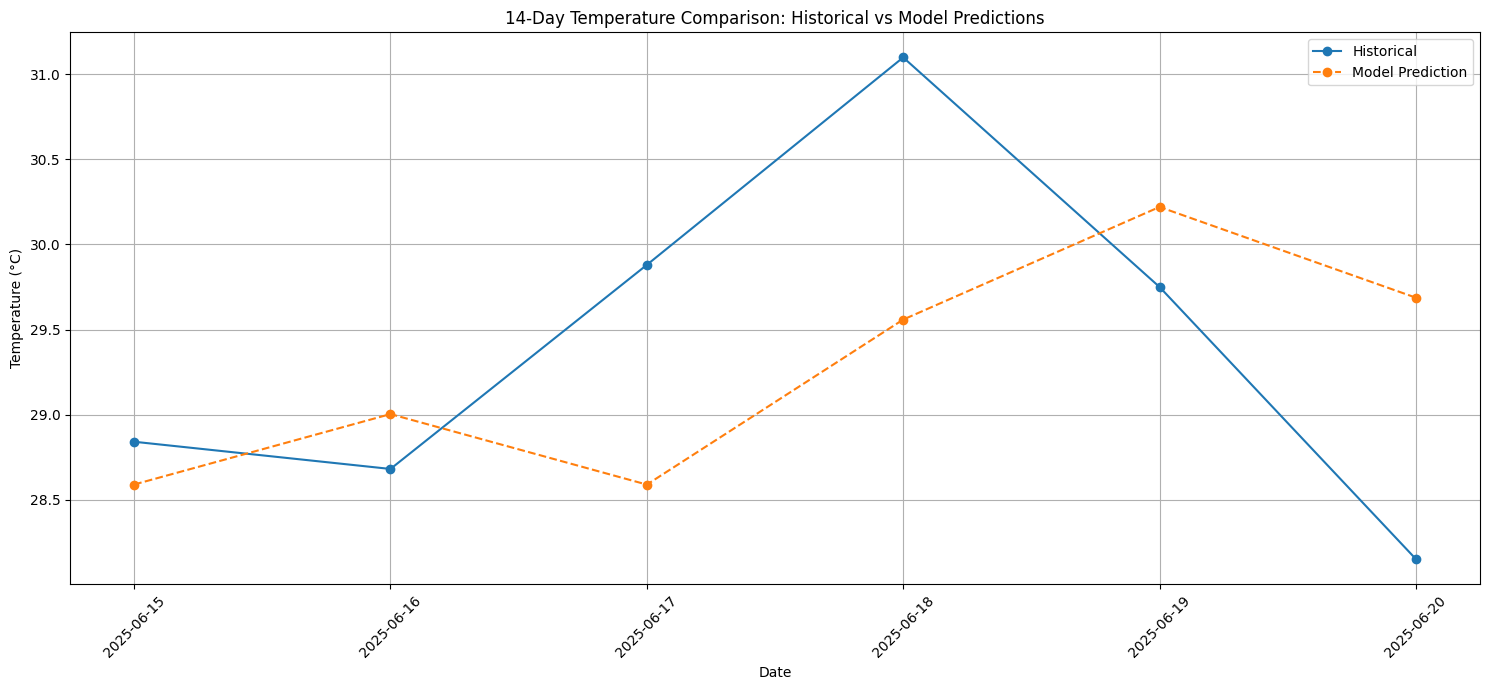

In [ ]:
# Create visualization
plt.figure(figsize=(15, 7))
plt.plot(forecast_df['Date'], forecast_df['TMAX'], label='Historical', marker='o')
plt.plot(forecast_df['Date'], forecast_df['Predicted_TMAX'], label='Model Prediction', marker='o', linestyle='--')
plt.title('14-Day Temperature Comparison: Historical vs Model Predictions')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Calculate and display error metrics
mse = mean_squared_error(forecast_df['TMAX'], forecast_df['Predicted_TMAX'])
mae = mean_absolute_error(forecast_df['TMAX'], forecast_df['Predicted_TMAX'])
r2 = r2_score(forecast_df['TMAX'], forecast_df['Predicted_TMAX'])

print("\nPerformance Metrics:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Calculate daily temperature differences
forecast_df['Temp_Difference'] = forecast_df['Predicted_TMAX'] - forecast_df['TMAX']
print("\nDaily Temperature Differences (Predicted - Actual):")
print(forecast_df[['Date', 'Temp_Difference']].to_string())




Performance Metrics:
Mean Squared Error: 1.1329
Mean Absolute Error: 0.9026
R² Score: -0.2057

Daily Temperature Differences (Predicted - Actual):
         Date  Temp_Difference
0  2025-06-15        -0.251427
1  2025-06-16         0.322644
2  2025-06-17        -1.291974
3  2025-06-18        -1.541561
4  2025-06-19         0.470606
5  2025-06-20         1.537132


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd

# GRU model definition – stable, layered, nothing too fancy
def create_gru_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        GRU(units=32, return_sequences=True, dropout=0.3, recurrent_dropout=0.2),
        Dropout(0.3),
        GRU(units=16, return_sequences=False, dropout=0.3, recurrent_dropout=0.2),
        Dropout(0.3),
        Dense(units=1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])
    return model


class BayesianEnsembleKalmanFilter:
    #found optimal base process noise to be 0.001
    def __init__(self, ensemble_size, model_class, input_shape, initial_params,
                 base_process_noise=0.001, base_observation_noise=0.01):
        self.ensemble_size = ensemble_size
        self.models = []
        self.param_means = []
        self.param_covs = []
        self.base_process_noise = base_process_noise
        self.base_observation_noise = base_observation_noise

        for _ in range(ensemble_size):
            model = model_class(input_shape)
            noisy_weights = [w + np.random.normal(0, 0.01, size=w.shape) for w in initial_params]
            model.set_weights(noisy_weights)
            self.models.append(model)
            self.param_means.append(noisy_weights)
            self.param_covs.append([np.eye(w.size) * base_process_noise for w in noisy_weights])

    def update(self, X, y_true):
            predictions = np.array([model(X, training=True).numpy().squeeze() for model in self.models])
            ensemble_mean = predictions.mean(axis=0)
            innovation = y_true - ensemble_mean #prediction error

            dynamic_observation_noise = np.var(innovation) + 1e-6 #uncertainty about the new data
            dynamic_process_noise = np.mean(np.abs(innovation)) * self.base_process_noise #parameter uncertainty
            for idx, model in enumerate(self.models):
                weights = model.get_weights()
                new_weights = []

                for w, cov in zip(weights, self.param_covs[idx]):
                    w_flat = w.flatten()
                    cov_diag = cov.diagonal()
                    gain_diag = cov_diag / (cov_diag + dynamic_observation_noise + 1e-8)
                    update_flat = gain_diag * innovation.mean()
                    w_updated = (w_flat + update_flat).reshape(w.shape)
                    new_weights.append(w_updated)

                model.set_weights(new_weights)
                self.param_means[idx] = new_weights

                #getting new covariance matrix
                self.param_covs[idx] = [
                    #hardcoded inflation factor to be 1.02. revisit.
                    np.eye(w.size) * dynamic_process_noise * 1.02
                    for w in new_weights
                ]

            return predictions



    def evaluate(self, X, y_true, alpha=0.1):
        ensemble_preds = self.update(X, y_true)
        mean_preds = ensemble_preds.mean(axis=0)

        mse = mean_squared_error(y_true, mean_preds)
        mae = mean_absolute_error(y_true, mean_preds)

        lower_bound = np.percentile(ensemble_preds, 100 * alpha / 2, axis=0)
        upper_bound = np.percentile(ensemble_preds, 100 * (1 - alpha / 2), axis=0)

        piw = (upper_bound - lower_bound).mean()
        picp = np.mean((y_true >= lower_bound) & (y_true <= upper_bound))

        return {
            'mse': mse,
            'mae': mae,
            'piw': piw,
            'picp': picp
        }



In [ ]:
import tensorflow as tf
import random
import os

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seed(42)

In [ ]:
# Data Subsampling Function


def subsample_data(X, y, fraction=0.6):
    num_samples = int(len(X) * fraction)
    indices = np.random.choice(len(X), size=num_samples, replace=False)
    return X[indices], y[indices]

# Initialize model
input_shape = X_train.shape[1:]
initial_weights = create_gru_model(input_shape).get_weights()

bekf = BayesianEnsembleKalmanFilter(
    ensemble_size=15,
    model_class=create_gru_model,
    input_shape=input_shape,
    initial_params=initial_weights,
)




In [ ]:
#training loop with data subsampling
num_epochs = 20
runs_per_epoch = 5

for epoch in range(num_epochs):
    mse_list, mae_list, piw_list, picp_list = [], [], [], []

    for _ in range(runs_per_epoch):
        X_batch, y_batch = subsample_data(X_train, y_train, fraction=0.5)
        metrics = bekf.evaluate(X_batch, y_batch, alpha=0.1)
        mse_list.append(metrics['mse'])
        mae_list.append(metrics['mae'])
        piw_list.append(metrics['piw'])
        picp_list.append(metrics['picp'])

    avg_mse = np.mean(mse_list)
    avg_mae = np.mean(mae_list)
    avg_piw = np.mean(piw_list)
    avg_picp = np.mean(picp_list)

    print(
        f"Epoch {epoch + 1}: "
        f"MSE = {avg_mse:.4f}, "
        f"MAE = {avg_mae:.4f}, "
        f"PIW = {avg_piw:.4f}, "
        f"PICP = {avg_picp:.2%}"
    )


Epoch 1: MSE = 0.1487, MAE = 0.3186, PIW = 1.0115, PICP = 73.04%
Epoch 2: MSE = 0.1286, MAE = 0.2991, PIW = 1.0091, PICP = 75.54%
Epoch 3: MSE = 0.0945, MAE = 0.2609, PIW = 1.0397, PICP = 84.09%
Epoch 4: MSE = 0.0540, MAE = 0.1925, PIW = 1.1765, PICP = 96.25%
Epoch 5: MSE = 0.0491, MAE = 0.1783, PIW = 1.3211, PICP = 98.41%
Epoch 6: MSE = 0.0534, MAE = 0.1866, PIW = 1.4101, PICP = 98.66%
Epoch 7: MSE = 0.0582, MAE = 0.1972, PIW = 1.4740, PICP = 98.85%
Epoch 8: MSE = 0.0635, MAE = 0.2065, PIW = 1.5245, PICP = 98.98%
Epoch 9: MSE = 0.0681, MAE = 0.2154, PIW = 1.5657, PICP = 98.85%
Epoch 10: MSE = 0.0721, MAE = 0.2225, PIW = 1.6034, PICP = 98.88%
Epoch 11: MSE = 0.0767, MAE = 0.2299, PIW = 1.6327, PICP = 98.76%
Epoch 12: MSE = 0.0793, MAE = 0.2337, PIW = 1.6624, PICP = 98.80%
Epoch 13: MSE = 0.0840, MAE = 0.2418, PIW = 1.6783, PICP = 98.78%
Epoch 14: MSE = 0.0856, MAE = 0.2436, PIW = 1.7003, PICP = 98.77%
Epoch 15: MSE = 0.0894, MAE = 0.2504, PIW = 1.7266, PICP = 98.78%
Epoch 16: MSE = 0.0

KeyboardInterrupt: 

111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step


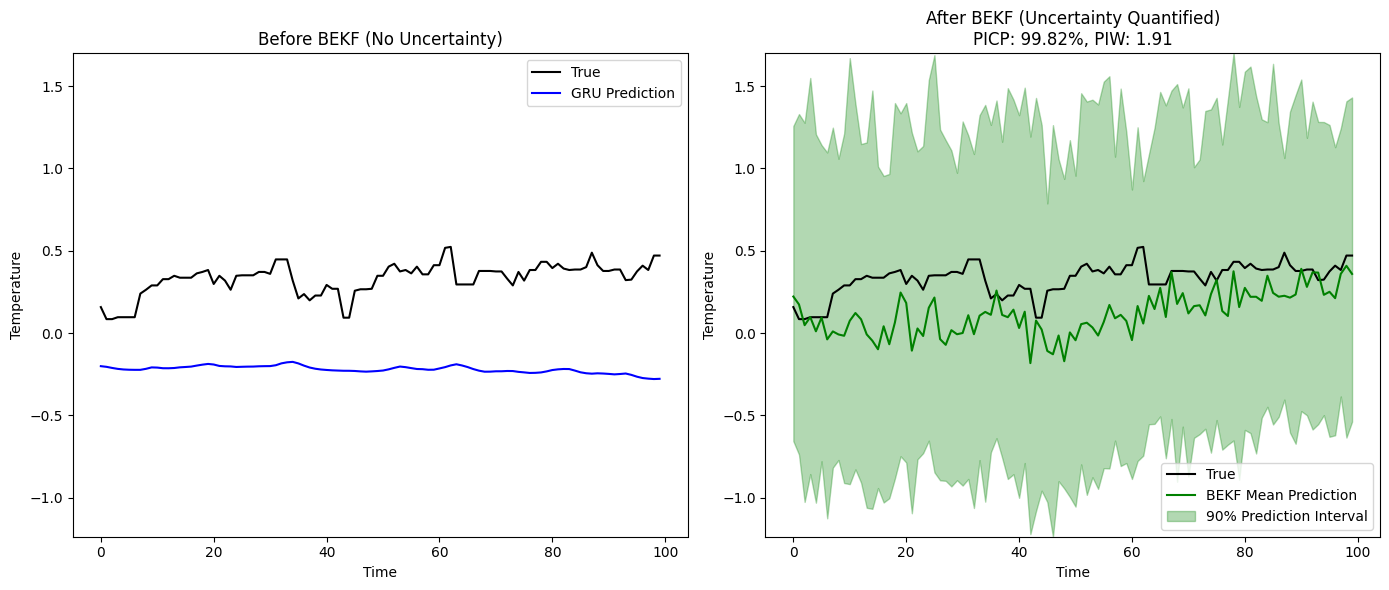

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predict with base model (no BEKF)
base_model = create_gru_model(input_shape)
base_model.set_weights(initial_weights)
base_preds = base_model.predict(X_test).squeeze()

# Evaluate BEKF: average over multiple runs
runs = 5
all_preds = []
picp_list = []
piw_list = []

for _ in range(runs):
    ensemble_preds = bekf.update(X_test, y_test)  # Shape: (ensemble_size, num_samples)
    all_preds.append(ensemble_preds)

    # Compute lower and upper percentiles
    lower = np.percentile(ensemble_preds, 5, axis=0)
    upper = np.percentile(ensemble_preds, 95, axis=0)

    # Compute metrics for this run
    picp = np.mean((y_test >= lower) & (y_test <= upper))
    piw = np.mean(upper - lower)

    picp_list.append(picp)
    piw_list.append(piw)

# Convert to array: shape (runs, ensemble_size, num_samples)
all_preds = np.array(all_preds)

# Compute ensemble mean and uncertainty bounds across runs and ensemble
ensemble_mean = all_preds.mean(axis=(0, 1))
lower_bound = np.percentile(all_preds, 5, axis=(0, 1))
upper_bound = np.percentile(all_preds, 95, axis=(0, 1))

# Average PICP and PIW across all runs
avg_picp = np.mean(picp_list)
avg_piw = np.mean(piw_list)

# Determine consistent y-limits
y_min = min(y_test[:100].min(), base_preds[:100].min(), lower_bound[:100].min())
y_max = max(y_test[:100].max(), base_preds[:100].max(), upper_bound[:100].max())

# Plot: GRU vs BEKF
plt.figure(figsize=(14, 6))

# ---- Base GRU ----
plt.subplot(1, 2, 1)
plt.plot(y_test[:100], label="True", color='black')
plt.plot(base_preds[:100], label="GRU Prediction", color='blue')
plt.title("Before BEKF (No Uncertainty)")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.ylim([y_min, y_max])
plt.legend()

# ---- BEKF ----
plt.subplot(1, 2, 2)
plt.plot(y_test[:100], label="True", color='black')
plt.plot(ensemble_mean[:100], label="BEKF Mean Prediction", color='green')
plt.fill_between(range(100), lower_bound[:100], upper_bound[:100],
                 color='green', alpha=0.3, label="90% Prediction Interval")
plt.title(f"After BEKF (Uncertainty Quantified)\nPICP: {avg_picp:.2%}, PIW: {avg_piw:.2f}")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.ylim([y_min, y_max])
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# GRU-only
mse_gru = mean_squared_error(y_test, base_preds)
mae_gru = mean_absolute_error(y_test, base_preds)

# --- Run BEKF multiple times to stabilize ---
runs = 5
bekf_metrics_list = []

for _ in range(runs):
    metrics = bekf.evaluate(X_test, y_test, alpha=0.1)
    bekf_metrics_list.append(metrics)

# Average metrics
mse_bekf = np.mean([m['mse'] for m in bekf_metrics_list])
mae_bekf = np.mean([m['mae'] for m in bekf_metrics_list])

# Report
print(f"Model MSE (Without BEKF): {mse_gru:.4f}")
print(f"Model MSE (With BEKF): {mse_bekf:.4f}")

print(f"Model MAE (Without BEKF): {mae_gru:.4f}")
print(f"Model MAE (With BEKF): {mae_bekf:.4f}")

print(f"MSE Improvement: {mse_gru - mse_bekf:.4f}")
print(f"MAE Improvement: {mae_gru - mae_bekf:.4f}")
print(f"Relative MAE Reduction: {(mae_gru - mae_bekf)/mae_gru:.2%}")
print(f"Relative MSE Reduction: {(mse_gru - mse_bekf)/mse_gru:.2%}")


Model MSE (Without BEKF): 0.9722
Model MSE (With BEKF): 0.0528
Model MAE (Without BEKF): 0.9620
Model MAE (With BEKF): 0.1838
MSE Improvement: 0.9194
MAE Improvement: 0.7782
Relative MAE Reduction: 80.90%
Relative MSE Reduction: 94.57%
